In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
train = pd.read_csv('/Users/cenkerarin/ml_test/datasets/cs-training.csv')
test = pd.read_csv('/Users/cenkerarin/ml_test/datasets/cs-test.csv')


In [3]:
X = train.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = train['SeriousDlqin2yrs']

X = X.fillna(X.median())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## CatBoost Parametrelerinin Açıklamaları

### Temel Parametreler

**iterations** = kaç round'da boost gerçekleşecek (n_estimators'ın karşılığı)

**learning_rate** = her boosting adımında güncelleme ne kadar yapılacak

**depth** = ağaçların maksimum derinliği

**l2_leaf_reg** = L2 regularizasyon parametresi (Ridge benzeri)

**model_size_reg** = model boyutu regularizasyonu

**rsm** = rastgele feature seçimi oranı (random subspace method)

### Kategorik Veri Parametreleri

**cat_features** = kategorik feature'ların indeksleri

**one_hot_max_size** = one-hot encoding için maksimum kategori sayısı

**max_ctr_complexity** = kategorik feature transformation'ların karmaşıklığı

### Overfitting Kontrol Parametreleri

**early_stopping_rounds** = kaç round boyunca iyileşme olmazsa dur

**use_best_model** = en iyi modeli kullan

**eval_metric** = değerlendirme metriği

### Performans Parametreleri

**task_type** = CPU veya GPU

**devices** = kullanılacak GPU'lar

**thread_count** = kullanılacak thread sayısı

### İleri Düzey Parametreler

**bootstrap_type** = bagging türü (Bayesian, Bernoulli, MVS)

**bagging_temperature** = Bayesian bootstrap sıcaklığı

**sampling_frequency** = örnekleme frekansı

**leaf_estimation_method** = yaprak değeri tahmin yöntemi

**grow_policy** = ağaç büyütme politikası

**penalties_coefficient** = ceza katsayısı

**first_feature_use_penalties** = ilk feature kullanım cezası

**model_shrink_rate** = model küçültme oranı


In [8]:
# CatBoost model oluşturma - Basit ve etkili parametreler
catboost_model = cb.CatBoostClassifier(
    # Temel parametreler
    iterations=1000,                    # Boost round sayısı
    learning_rate=0.1,                  # Öğrenme oranı
    depth=6,                           # Ağaç derinliği
    l2_leaf_reg=3.0,                   # L2 regularizasyon
    
    # Loss function ve metrik
    loss_function='Logloss',           # Kayıp fonksiyonu
    eval_metric='AUC',                 # Değerlendirme metriği
    
    # Overfitting kontrol
    early_stopping_rounds=50,          # Erken durdurma
    use_best_model=True,               # En iyi modeli kullan
    
    # Kategorik veri parametreleri
    one_hot_max_size=2,                # One-hot encoding max size
    
    # Sampling parametreleri
    subsample=0.8,                     # Subsample oranı
    
    # Performans parametreleri
    thread_count=-1,                   # Thread sayısı (-1: tüm core'lar)
    task_type='CPU',                   # Task tipi (CPU/GPU)
    
    # Diğer parametreler
    random_seed=42,                    # Random seed
    verbose=True                       # Verbose output
)

# Model eğitimi
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=False,                        # Eğitim grafiği
    verbose_eval=50                    # Verbose evaluation
)


0:	test: 0.7943874	best: 0.7943874 (0)	total: 72ms	remaining: 1m 11s
50:	test: 0.8683574	best: 0.8683779 (49)	total: 622ms	remaining: 11.6s
100:	test: 0.8697920	best: 0.8698319 (98)	total: 1.19s	remaining: 10.6s
150:	test: 0.8704506	best: 0.8704506 (149)	total: 1.63s	remaining: 9.18s
200:	test: 0.8704743	best: 0.8705535 (181)	total: 2.06s	remaining: 8.2s
250:	test: 0.8706045	best: 0.8706047 (234)	total: 2.49s	remaining: 7.42s
300:	test: 0.8702641	best: 0.8706353 (254)	total: 2.92s	remaining: 6.78s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8706353334
bestIteration = 254

Shrink model to first 255 iterations.


In [9]:
# Tahmin yapma
y_pred = catboost_model.predict(X_val)
y_pred_proba = catboost_model.predict_proba(X_val)[:, 1]

# Model değerlendirme
accuracy = accuracy_score(y_val, y_pred)
print(f"CatBoost Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

CatBoost Accuracy: 0.9380

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27995
           1       0.61      0.20      0.30      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000


Confusion Matrix:
[[27742   253]
 [ 1606   399]]


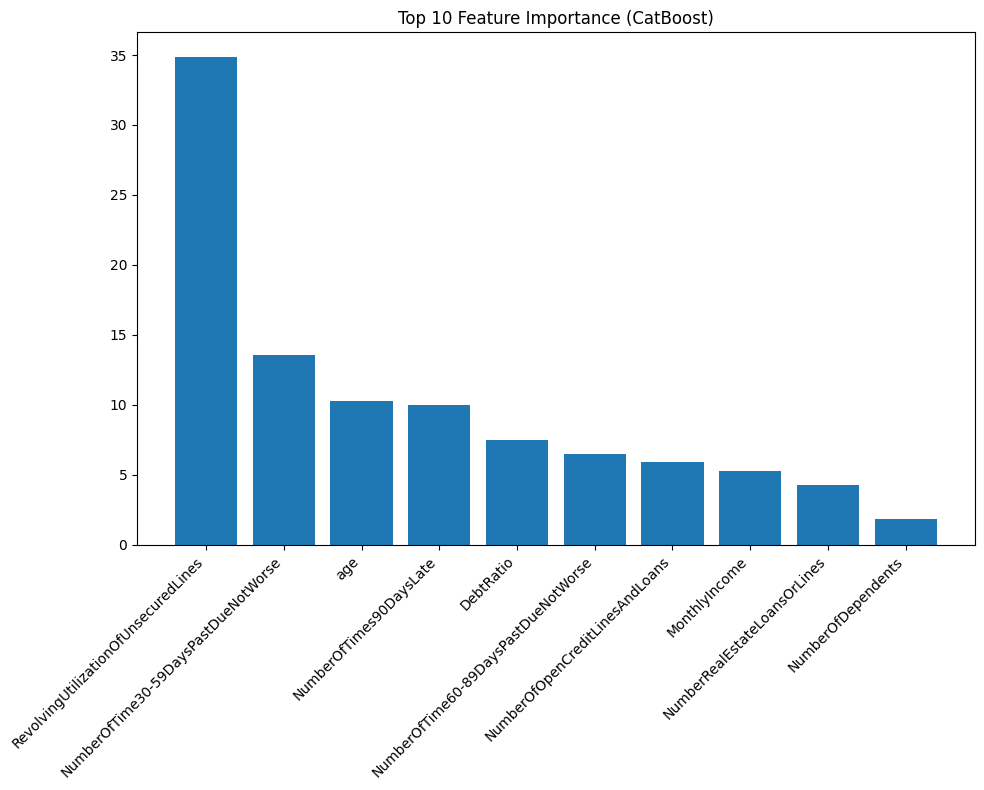

In [11]:
# Feature importance görselleştirme
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importance)[::-1][:10]
plt.title("Top 10 Feature Importance (CatBoost)")
plt.bar(range(10), feature_importance[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:
# Test verisi üzerinde tahmin yapma
if 'SeriousDlqin2yrs' in test.columns:
    X_test = test.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1)
else:
    X_test = test.drop(['Unnamed: 0'], axis=1)

# Feature'ları eğitim verisi ile aynı sıraya getir
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Missing value'ları doldur
X_test = X_test.fillna(X_test.median())

# Test verisi tahminleri
test_predictions = catboost_model.predict_proba(X_test)[:, 1]

# Submission dosyası oluşturma
submission = pd.DataFrame({
    'Id': test['Unnamed: 0'],
    'Probability': test_predictions
})

# submission.to_csv('catboost_submission.csv', index=False)